In [14]:
import copy
import numpy as np
from Trip import Trip
from Point import Point
from Trips import Trips
import math
import matplotlib.pyplot as plt
import gurobipy as gb
from Simulation import Simulation
from Solver import Solver


In [15]:
#  customized clustering procedure
def cc_procedure(n,m,J,D,start_point, end_point):
    # n is number of realocation moves J={1, ..., n}
    # m is number of realocators R={1, ..., m}

    realocation_moves=copy.deepcopy(J)
    trips=[]

    while len(realocation_moves)>0:
        drop_off_points=copy.deepcopy(D)
        #initialize a new Trip
        new_trip=Trip([],[],0)

        p=np.floor(n/m)/(np.floor(n/m)+1)
        # TODO controllare
        if np.random.uniform(0,1)<=p:
            n_hat=np.random.randint(np.ceil((m+1)/2),m+1)
        else:
            n_hat=np.random.randint(1,np.ceil((m+1)/2)+1) #TODO sistemare che metta il secondo incluso

        j=realocation_moves[np.random.randint(0,len(realocation_moves))] # len(J) = |J| forse si puo` usare choice meglio
        # update
        new_trip.J.append(j) #J'={j}
        realocation_moves.remove(j) # J=J\{j}   P= (u_j^c,v_j^c)

        while len(new_trip.J)<n_hat and len(realocation_moves)!=0:
            p=[]
            for j in realocation_moves:
                p_j=0.0
                for q in J:
                    distance_j=new_trip.distance_from_cluster_center(j)
                    distance_q=new_trip.distance_from_cluster_center(q)
                    p_j+=distance_j/distance_q if distance_q!=0 else 0
                p.append(p_j**-1 if p_j!=0 else 0.0)
            j=np.random.choice(realocation_moves, 1, p)[0] # sample from J
            new_trip.J.append(j) #J'={j} # TODO sistemare si può mettere un metodo dentro Trip
            realocation_moves.remove(j) # J=J\{j}

        # line 7
        probability=[]
        for selected_pi in drop_off_points:
            p_pi=0.0
            for q in drop_off_points:
                distance_pi=new_trip.distance_from_cluster_center(selected_pi)
                sum_distance_dropoff=new_trip.distance_from_cluster_center(q)
                p_pi+=distance_pi/sum_distance_dropoff if sum_distance_dropoff!=0 else 0
            probability.append(p_pi**-1 if p_pi!=0 else 0.0)


        pi_l=np.random.choice(drop_off_points, 1, probability)[0]

        new_trip.pi.append(start_point)
        new_trip.pi.append(pi_l) # pi={pi_l} #TODO  sistemare con un metodo
        new_trip.pi.append(end_point)
        new_trip.k=1

        drop_off_points.remove(pi_l) # D=D\{pi_l}

        #calculate total duration C of taxi trip pi according to relocation J'
        C=new_trip.trip_duration()

        while len(drop_off_points)!=0:
            #determine drop-off point q in D which decreases C most
            q_min=None
            for q in drop_off_points:
                new_trip.pi.insert(len(new_trip.pi) - 1, q)
                C_new=new_trip.get_pure_taxi_trip()
                if C_new < C:
                    q_min=q
                new_trip.pi.remove(q)

            if(q_min != None):
                new_trip.pi.insert(len(new_trip.pi) - 1, q_min)
                new_trip.k+=1
                drop_off_points.remove(q_min)
            else:
                drop_off_points=[]

        trips.append(new_trip)

    return trips

In [56]:
n,m,ks,kr,kn,T_start,c=Simulation.get_simulation_number(0)

In [57]:
J,D=Simulation.initialize_map(n)

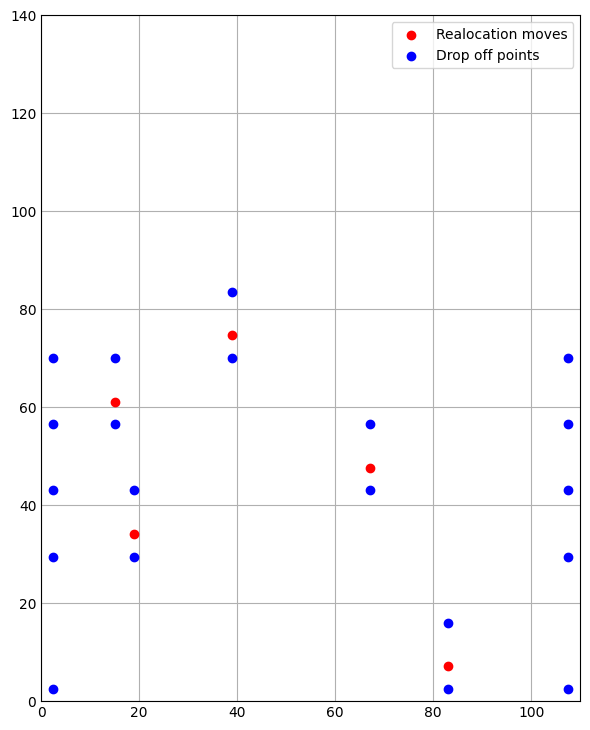

In [58]:
Simulation.plot_map(J,D,[],figsize=(5.5,7))

In [59]:
trips=cc_procedure(n,m,J,D,Point(0,0), Point(0,0))

In [60]:
trips


[<Trip.Trip at 0x11b31d5a0>, <Trip.Trip at 0x11b31d780>]

In [61]:
Trips.get_total_duration(trips)

111.11933862341093

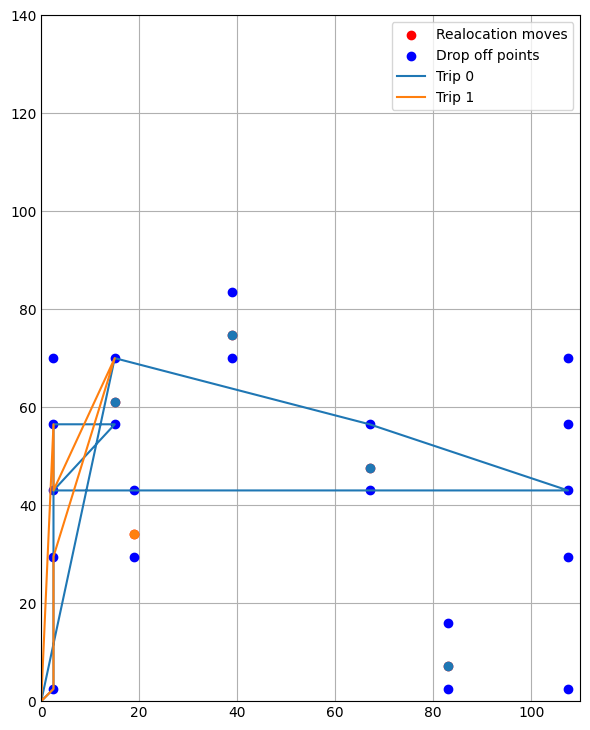

In [62]:
Simulation.plot_map(J,D,trips,figsize=(5.5,7))

In [48]:
print(trips[3])


J: (99,115.125) (75,105.875) (11,38.375) (35,38.375) (7,92.375) (83,105.875) (75,132.875) (99,92.375) pi: (0,0) (99,124.0) (2.5,110.5) (2.5,110.5) (2.5,110.5) (2.5,110.5) (2.5,110.5) (2.5,110.5) (2.5,110.5) (43,70.0) (43,56.5) (2.5,83.5) (2.5,56.5) (0,0) k=12


In [5]:
x=[]
print(len(x))


0
